In [1]:
# Practical Application III: Comparing Classifiers
# Bank Marketing Campaign Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from tabulate import tabulate
import time
import logging
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime

def configureLogging(logfile):
  # Create logger
  logger = logging.getLogger(__name__)
  logger.setLevel(logging.INFO)

  # Clear any existing handlers
  for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

  # Create file handler
  file_handler = logging.FileHandler(logfile)
  file_handler.setLevel(logging.INFO)

  # Create console handler
  console_handler = logging.StreamHandler()
  console_handler.setLevel(logging.INFO)

  # Create formatter and add it to the handlers
  formatter = logging.Formatter('%(asctime)s - %(message)s', '%Y-%m-%d %H:%M:%S')
  file_handler.setFormatter(formatter)
  console_handler.setFormatter(formatter)

  # Add the handlers to the logger
  logger.addHandler(file_handler)
  logger.addHandler(console_handler)

  # Now you can use logger to log messages to both file and console
  # logger.info("This message will go to both file and console")
  # Configure logging
  return logger





### Problem 1: Understanding the Data

#### The dataset represents multiple direct marketing campaigns (phone calls) of a Portuguese banking institution.
#### According to the UCI repository information, the data contains results from multiple marketing campaigns.
#### The campaigns ran from May 2008 to November 2010, representing 17 different campaigns.

### Problem 2: Read in the Data

In [3]:
def load_data(file_path, separator=';', encoding='utf-8'):
    """
    Load the dataset from the given file path with error handling.
    """
    try:
        logger.info(f"Loading data from {file_path}")
        df = pd.read_csv(file_path, sep=separator, encoding=encoding)
        logger.info(f"Successfully loaded data with shape: {df.shape}")
        return df
    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        return None
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        return None


In [4]:
### Problem 3: Understanding the Features

def explore_data(df):
    """
    Perform initial exploration of the dataset.
    """
    if df is None or df.empty:
        logger.error("Cannot explore empty or None dataframe")
        return None

    try:
        # Check for missing values
        logger.info(f"Missing Values Check:")
        missing_values = df.isnull().sum()
        if missing_values.sum() > 0:
            logger.info(f"Missing values: {missing_values.sum()}")
        else:
            logger.info(f"No missing values found")

        # Check for 'unknown' values in categorical columns
        logger.info(f"Unknown Values in Categorical Columns:")
        categorical_cols = df.select_dtypes(include=['object']).columns
        unknown_counts = {}
        for col in categorical_cols:
            count = (df[col] == 'unknown').sum()
            if count > 0:
                logger.info(f"{col}: {count} unknown values ({count/len(df)*100:.2f}%)")

        # Target variable distribution
        logger.info(f"Target Variable Distribution:")
        logger.info(f"{df['y'].value_counts()}")
        logger.info(f"{df['y'].value_counts(normalize=True).round(4) * 100}")

        # Numeric columns statistics
        logger.info("Numeric Columns Statistics:")
        with pd.option_context('display.max_columns', None, 'display.expand_frame_repr', False, 'display.max_rows', 5, 'display.width', 1000):
          logger.info(df.describe())

        logger.info("Data exploration completed")
        return True
    except Exception as e:
        logger.error(f"Error during data exploration: {str(e)}")
        return None


In [5]:
### Problem 4: Understanding the Task

def define_business_objective():
    """
    Define the business objective of the analysis.
    """
    objective = """
    Business Objective:
    To develop a predictive model that identifies clients likely to subscribe to a term deposit
    based on client information and campaign data. This will help the bank:

    1. Optimize marketing resource allocation by targeting clients with higher conversion probability
    2. Increase the conversion rate of marketing campaigns
    3. Reduce costs by minimizing contacts with low-probability clients
    4. Improve customer experience by reducing unwanted solicitations
    5. Maximize return on investment (ROI) for marketing campaigns

    The model's predictions will inform the prioritization of clients for contact in future
    marketing campaigns, leading to more efficient operations and higher subscription rates.
    """
    return objective

In [6]:
### Problem 5: Engineering Features

def prepare_features_and_target(df, feature_set='all'):
    """
    Prepare features and target variable for modeling.
    """
    if df is None or df.empty:
        logger.error("Cannot prepare features for empty or None dataframe")
        return None, None

    try:
        # Prepare target variable
        y = df['y'].map({'yes': 1, 'no': 0})

        # Select features based on feature_set
        if feature_set == 'basic':
            # Basic client information only
            features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
        elif feature_set == 'all':
            # All features except duration (as recommended in dataset description)
            features = [col for col in df.columns if col not in ['y', 'duration']]
        else:
            logger.error(f"Invalid feature set: {feature_set}")
            return None, None

        X = df[features]
        logger.info(f"Prepared features ({X.shape[1]} features) and target")
        return X, y

    except Exception as e:
        logger.error(f"Error preparing features and target: {str(e)}")
        return None, None

def create_preprocessor(X):
    """
    Create a preprocessing pipeline for the features.
    """
    if X is None or X.empty:
        logger.error("Cannot create preprocessor for empty or None dataframe")
        return None

    try:
        # Identify categorical and numerical columns
        categorical_cols = X.select_dtypes(include=['object']).columns
        numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

        # Create preprocessing for categorical data
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        # Create preprocessing for numeric data
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        # Combine preprocessors
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

        logger.info("Created feature preprocessor")
        return preprocessor

    except Exception as e:
        logger.error(f"Error creating preprocessor: {str(e)}")
        return None


In [7]:
### Problem 6: Train/Test Split

def train_test_data_split(X, y, test_size=0.25, random_state=42):
    """
    Split data into train and test sets.
    """
    if X is None or y is None:
        logger.error("Cannot split None data")
        return None, None, None, None

    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        logger.info(f"Data split - Training: {X_train.shape}, Test: {X_test.shape}")
        return X_train, X_test, y_train, y_test

    except Exception as e:
        logger.error(f"Error splitting data: {str(e)}")
        return None, None, None, None

In [8]:
### Problem 7: A Baseline Model

def calculate_baseline(y_train, y_test):
    """
    Calculate baseline performance metrics.
    """
    if y_train is None or y_test is None:
        logger.error("Cannot calculate baseline for None data")
        return None

    try:
        # Calculate class proportions
        train_pos_ratio = np.mean(y_train)

        # Determine majority class
        majority_class = int(train_pos_ratio < 0.5)
        majority_label = "No (0)" if majority_class == 0 else "Yes (1)"

        # Make predictions using majority class
        y_pred = np.full_like(y_test, majority_class)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)

        baseline_metrics = {
            'majority_class': majority_label,
            'positive_ratio': train_pos_ratio,
            'accuracy': accuracy,
            'roc_auc': 0.5  # Random predictions have AUC of 0.5
        }

        logger.info("Baseline Model:")
        logger.info(f"Majority class: {majority_label}")
        logger.info(f"Positive class ratio in training: {train_pos_ratio:.4f}")
        logger.info(f"Baseline accuracy: {accuracy:.4f}")
        logger.info(f"Baseline ROC-AUC: 0.5 (random predictions)")

        logger.info(f"Calculated baseline metrics: {baseline_metrics}")
        return baseline_metrics

    except Exception as e:
        logger.error(f"Error calculating baseline: {str(e)}")
        return None

In [9]:
### Problem 8 & 9: A Simple Model & Score the Model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name=None):
    """
    Train and evaluate a single model with tabular formatted output.
    """
    if model is None or X_train is None or y_train is None or X_test is None or y_test is None:
        logger.error("Cannot train and evaluate with None inputs")
        return None

    if model_name is None:
        model_name = model.__class__.__name__

    try:
        # Train model and measure time
        logger.info(f"{'='*60}\nTraining and Evaluating {model_name}:")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_test_pred)

        # Create metrics table data
        metrics_data = [
            ["Training Time", f"{train_time:.2f} seconds", ""],
            ["Accuracy", f"{train_accuracy:.4f}", f"{test_accuracy:.4f}"],
            ["F1 Score", f"{train_f1:.4f}", f"{test_f1:.4f}"]
        ]

        metrics = {
            'model_name': model_name,
            'train_time': train_time,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_f1': train_f1,
            'test_f1': test_f1
        }

        # ROC-AUC if available
        if hasattr(model, "predict_proba"):
            y_train_prob = model.predict_proba(X_train)[:, 1]
            y_test_prob = model.predict_proba(X_test)[:, 1]

            train_roc_auc = roc_auc_score(y_train, y_train_prob)
            test_roc_auc = roc_auc_score(y_test, y_test_prob)

            metrics['train_roc_auc'] = train_roc_auc
            metrics['test_roc_auc'] = test_roc_auc

            metrics_data.insert(2, ["ROC-AUC", f"{train_roc_auc:.4f}", f"{test_roc_auc:.4f}"])

        # Generate classification report and convert to DataFrame
        cl_report = classification_report(y_test, y_test_pred, output_dict=True)
        report_df = pd.DataFrame(cl_report).transpose()

        # Output tabular results
        logger.info("\n" + tabulate(
            metrics_data,
            headers=["Metric", "Training Set", "Test Set"],
            tablefmt="pretty"
        ))

        logger.info("\nClassification Report:")
        logger.info("\n" + tabulate(
            report_df.round(3),
            headers='keys',
            tablefmt="pretty"
        ))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No', 'Yes'],
                    yticklabels=['No', 'Yes'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.tight_layout()
        plt.show()

        logger.info(f"{'='*60}\n")
        return metrics, model

    except Exception as e:
        logger.error(f"Error training and evaluating {model_name}: {str(e)}")
        return None, None

In [10]:
### Problem 10: Model Comparisons

def compare_models(X_train, y_train, X_test, y_test):
    """
    Compare multiple classification models.
    """
    if X_train is None or y_train is None or X_test is None or y_test is None:
        logger.error("Cannot compare models with None inputs")
        return None

    try:
        # Initialize models
        models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'KNN': KNeighborsClassifier(),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'SVM': SVC(probability=True, random_state=42)
        }

        # Train and evaluate each model
        results = {}
        trained_models = {}

        for name, model in models.items():
            metrics, trained_model = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, name)
            if metrics is not None:
                results[name] = metrics
                trained_models[name] = trained_model

        # Create comparison DataFrame
        if results:
            df_data = []
            for name, metrics in results.items():
                row = {
                    'Model': name,
                    'Train Time (s)': metrics.get('train_time', np.nan),
                    'Train Accuracy': metrics.get('train_accuracy', np.nan),
                    'Test Accuracy': metrics.get('test_accuracy', np.nan)
                }

                if 'train_roc_auc' in metrics:
                    row['Train ROC-AUC'] = metrics.get('train_roc_auc', np.nan)
                    row['Test ROC-AUC'] = metrics.get('test_roc_auc', np.nan)

                row['Train F1'] = metrics.get('train_f1', np.nan)
                row['Test F1'] = metrics.get('test_f1', np.nan)

                df_data.append(row)

            comparison_df = pd.DataFrame(df_data)
            comparison_df.set_index('Model', inplace=True)

            logger.info("Model Comparison:")
            logger.info(comparison_df.round(4))

            # Visualize comparison
            plt.figure(figsize=(12, 6))
            comparison_df[['Test Accuracy', 'Test ROC-AUC', 'Test F1']].plot(kind='bar')
            plt.title('Model Performance Comparison')
            plt.ylabel('Score')
            plt.ylim(0, 1)
            plt.tight_layout()
            plt.show()

            logger.info("Completed model comparison")
            return comparison_df, trained_models
        else:
            logger.error("No models were successfully evaluated")
            return None, None

    except Exception as e:
        logger.error(f"Error comparing models: {str(e)}")
        return None, None

In [11]:
### Problem 11: Improving the Model
def tune_model_hyperparameters(model, param_grid, X_train, y_train, X_test, y_test, model_name=None, cv=5, scoring='roc_auc'):
    """
    Tune model hyperparameters using GridSearchCV or handle pre-configured search objects.
    """
    if model is None or X_train is None or y_train is None:
        logger.error("Cannot tune hyperparameters with None inputs")
        return None, None

    if model_name is None:
        model_name = model.__class__.__name__

    try:
        logger.info(f"Tuning {model_name} Hyperparameters:")

        # Check if the model is already a search object (RandomizedSearchCV or GridSearchCV)
        from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

        if isinstance(model, (RandomizedSearchCV, GridSearchCV)):
            logger.info(f"Using pre-configured {model.__class__.__name__} for {model_name}")

            # The model is already a search object, so we can fit it directly
            model.fit(X_train, y_train)

            # Get best parameters and score
            best_params = model.best_params_
            best_score = model.best_score_
            best_model = model.best_estimator_

        else:
            # Create cross-validation splitter
            cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

            # Create grid search
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv_splitter,
                scoring=scoring,
                n_jobs=-1,
                verbose=1
            )

            # Fit grid search
            grid_search.fit(X_train, y_train)

            # Get best parameters and score
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            best_model = grid_search.best_estimator_

        logger.info(f"Best parameters: {best_params}")
        logger.info(f"Best CV {scoring} score: {best_score:.4f}")

        # Evaluate the tuned model
        metrics, _ = train_and_evaluate_model(best_model, X_train, y_train, X_test, y_test, f"Tuned {model_name}")

        logger.info(f"Completed hyperparameter tuning for {model_name}")
        return best_model, metrics

    except Exception as e:
        logger.error(f"Error tuning hyperparameters for {model_name}: {str(e)}")
        return None, None

In [12]:
def optimize_models(X_train, y_train, X_test, y_test):
    """
    Optimize each model through hyperparameter tuning.
    """
    if X_train is None or y_train is None or X_test is None or y_test is None:
        logger.error("Cannot optimize models with None inputs")
        return None

    try:
        # Import RandomizedSearchCV if not already imported
        from sklearn.model_selection import RandomizedSearchCV
        import numpy as np

        # Define parameter grids for each model
        param_grids = {
            'Logistic Regression': {
                'model': LogisticRegression(random_state=42, max_iter=2000),
                'params': {
                    'C': [0.01, 0.1, 1, 10, 100],
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear'],
                    'class_weight': [None, 'balanced']
                }
            },
            'KNN': {
                'model': KNeighborsClassifier(),
                'params': {
                    'n_neighbors': [3, 5, 7, 11, 15],
                    'weights': ['uniform', 'distance'],
                    'p': [1, 2]
                }
            },
            'Decision Tree': {
                'model': DecisionTreeClassifier(random_state=42),
                'params': {
                    'max_depth': [None, 5, 10, 15],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'class_weight': [None, 'balanced']
                }
            },

            'SVM': {
                'model': RandomizedSearchCV(
                    estimator=SVC(probability=True, random_state=42),
                    param_distributions={
                        'C': [1],                    # Reduced from 5 to 2 values
                        'gamma': ['scale'],               # Reduced from 2 to 1 value
                        'kernel': ['rbf'],                # Just use rbf kernel
                        'class_weight': [None]            # Removed 'balanced' option
                    },
                    n_iter=2,                             # Reduced from 10 to 2 iterations
                    cv=2,                                 # Reduced from 5-fold to 2-fold CV
                    scoring='roc_auc',
                    random_state=42,
                    n_jobs=-1
                ),
                'params': {}
            }
        }

        # Rest of the function remains the same
        best_models = {}
        best_metrics = {}

        for name, config in param_grids.items():
            print(f"Optimizing {name}...")
            best_model, metrics = tune_model_hyperparameters(
                config['model'], config['params'],
                X_train, y_train, X_test, y_test,
                model_name=name
            )

            if best_model is not None and metrics is not None:
                best_models[name] = best_model
                best_metrics[name] = metrics

        # Create comparison DataFrame for optimized models
        if best_metrics:
            df_data = []
            for name, metrics in best_metrics.items():
                row = {
                    'Model': f"Tuned {name}",
                    'Test Accuracy': metrics.get('test_accuracy', np.nan),
                    'Test ROC-AUC': metrics.get('test_roc_auc', np.nan),
                    'Test F1': metrics.get('test_f1', np.nan)
                }
                df_data.append(row)

            optimized_df = pd.DataFrame(df_data)
            optimized_df.set_index('Model', inplace=True)

            logger.info("Optimized Model Comparison:")
            logger.info(optimized_df.round(4))

            # Visualize comparison
            plt.figure(figsize=(12, 6))
            optimized_df.plot(kind='bar')
            plt.title('Optimized Model Performance Comparison')
            plt.ylabel('Score')
            plt.ylim(0, 1)
            plt.tight_layout()
            plt.show()

            # Find best model
            best_metric = 'test_roc_auc' if 'test_roc_auc' in next(iter(best_metrics.values())) else 'test_accuracy'
            best_model_name = max(best_metrics, key=lambda k: best_metrics[k].get(best_metric, 0))

            logger.info(f"Best Model: Tuned {best_model_name}")

            logger.info("Completed model optimization")
            return {
                'optimized_models': best_models,
                'best_model_name': best_model_name,
                'best_model': best_models[best_model_name],
                'comparison_df': optimized_df
            }
        else:
            logger.error("No models were successfully optimized")
            return None

    except Exception as e:
        logger.error(f"Error optimizing models: {str(e)}")
        return None

In [13]:
# Additional stuff to get to Business Recommendation
def cross_validate_model(model, X, y, cv=10, scoring=['roc_auc', 'accuracy', 'f1']):
    """
    Perform cross-validation on the final model.
    """
    if model is None or X is None or y is None:
        logger.error("Cannot cross-validate with None inputs")
        return None

    try:
        logger.info(f"Cross-Validation Results ({cv}-fold):")

        results = {}
        for metric in scoring:
            scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            results[metric] = {
                'scores': scores,
                'mean': mean_score,
                'std': std_score
            }

            logger.info(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

        logger.info("Completed cross-validation")
        return results

    except Exception as e:
        logger.error(f"Error in cross-validation: {str(e)}")
        return None

def get_feature_importance(model, feature_names, top_n=20):
    """
    Get and visualize feature importance.
    """
    if model is None or feature_names is None:
        logger.error("Cannot get feature importance with None inputs")
        return None

    try:
        if hasattr(model, 'coef_'):
            # Linear models (LogisticRegression, LinearSVC, etc.)
            importance = model.coef_[0]
            importance_type = 'Coefficient'
        elif hasattr(model, 'feature_importances_'):
            # Tree-based models (DecisionTree, RandomForest, etc.)
            importance = model.feature_importances_
            importance_type = 'Importance'
        else:
            logger.info("Model does not provide feature importance")
            return None

        # Ensure correct length
        if len(feature_names) != len(importance):
            logger.warning(f"Length mismatch: {len(feature_names)} features vs {len(importance)} importance values")
            feature_names = feature_names[:len(importance)]

        # Create DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            importance_type: importance,
            'Absolute': np.abs(importance)
        })

        # Sort by absolute importance
        importance_df = importance_df.sort_values('Absolute', ascending=False).head(top_n)

        # Visualize
        plt.figure(figsize=(12, 8))
        sns.barplot(x=importance_type, y='Feature', data=importance_df)
        plt.title(f'Top {top_n} Feature Importance')
        plt.tight_layout()
        plt.show()

        logger.info("Completed feature importance analysis")
        return importance_df

    except Exception as e:
        logger.error(f"Error in feature importance: {str(e)}")
        return None


In [14]:
def generate_business_recommendations(model, feature_names, baseline_metrics, final_metrics):
    """
    Generate business recommendations based on model insights.
    """
    if model is None:
        logger.error("Cannot generate recommendations for None model")
        return None

    try:
        # Get feature importance
        importance_df = get_feature_importance(model, feature_names, top_n=10)

        # Calculate improvements
        accuracy_improvement = final_metrics.get('test_accuracy', 0) - baseline_metrics.get('accuracy', 0)
        if 'test_roc_auc' in final_metrics:
            roc_auc_improvement = final_metrics.get('test_roc_auc', 0) - baseline_metrics.get('roc_auc', 0)
        else:
            roc_auc_improvement = 0

        # Generate consolidated recommendations string
        recommendation_lines = []
        recommendation_lines.append("="*80)
        recommendation_lines.append("BUSINESS FINDINGS AND RECOMMENDATIONS")
        recommendation_lines.append("="*80)
        recommendation_lines.append("")

        recommendation_lines.append("## Summary of Findings")
        recommendation_lines.append(f"\n1. Model Performance:")
        recommendation_lines.append(f"   - Our model achieved {final_metrics.get('test_accuracy', 0)*100:.1f}% accuracy, an improvement of {accuracy_improvement*100:.1f}% over the baseline.")
        if 'test_roc_auc' in final_metrics:
            recommendation_lines.append(f"   - ROC-AUC score of {final_metrics.get('test_roc_auc', 0):.4f}, which is {roc_auc_improvement:.4f} higher than random guessing.")
        recommendation_lines.append(f"   - F1 score of {final_metrics.get('test_f1', 0):.4f}, indicating balanced precision and recall.")

        recommendation_lines.append("\n2. Key Factors Influencing Term Deposit Subscriptions:")
        if importance_df is not None:
            for i, (_, row) in enumerate(importance_df.iterrows()[:5], 1):
                direction = "positively" if row.iloc[1] > 0 else "negatively"
                recommendation_lines.append(f"   - {row['Feature']} influences subscription likelihood {direction}")

        recommendation_lines.append("\n## Actionable Recommendations")

        recommendation_lines.append("\n1. Optimize Campaign Timing:")
        recommendation_lines.append("   - Focus campaigns during months with historically higher success rates")
        recommendation_lines.append("   - Consider economic indicators when planning campaigns")

        recommendation_lines.append("\n2. Prioritize High-Potential Clients:")
        recommendation_lines.append("   - Create a tiered approach to client outreach, focusing on segments with higher conversion probability")
        recommendation_lines.append("   - Specifically target clients who showed interest in previous campaigns")

        recommendation_lines.append("\n3. Refine Contact Strategy:")
        recommendation_lines.append("   - Prefer cellular contact over telephone when possible")
        recommendation_lines.append("   - Optimize call scripts based on client demographics")

        recommendation_lines.append("\n4. Implementation Plan:")
        recommendation_lines.append("   - Integrate the predictive model into the marketing workflow")
        recommendation_lines.append("   - Develop a lead scoring system based on model predictions")
        recommendation_lines.append("   - Set up A/B testing to validate model-based targeting")
        recommendation_lines.append("   - Measure and evaluate performance improvements")

        recommendation_lines.append("\n## Expected Benefits")

        # Calculate estimated ROI (hypothetical)
        baseline_conversion = 0.113  # Approximately 11.3% from the dataset
        estimated_new_conversion = baseline_conversion + roc_auc_improvement * 1.5  # Simple estimation

        campaign_size = 10000  # Hypothetical campaign size
        cost_per_contact = 10  # Hypothetical cost in euros
        profit_per_conversion = 1000  # Hypothetical profit in euros

        baseline_conversions = campaign_size * baseline_conversion
        baseline_profit = baseline_conversions * profit_per_conversion - campaign_size * cost_per_contact

        new_conversions = campaign_size * estimated_new_conversion
        new_profit = new_conversions * profit_per_conversion - campaign_size * cost_per_contact

        profit_increase = new_profit - baseline_profit
        roi_percentage = (profit_increase / (campaign_size * cost_per_contact)) * 100

        recommendation_lines.append(f"\n1. Financial Impact (Estimates):")
        recommendation_lines.append(f"   - Current conversion rate: {baseline_conversion*100:.1f}%")
        recommendation_lines.append(f"   - Estimated new conversion rate: {estimated_new_conversion*100:.1f}%")
        recommendation_lines.append(f"   - For a campaign of {campaign_size} contacts:")
        recommendation_lines.append(f"     * Current profit: €{baseline_profit:,.2f}")
        recommendation_lines.append(f"     * Estimated new profit: €{new_profit:,.2f}")
        recommendation_lines.append(f"     * Potential profit increase: €{profit_increase:,.2f}")
        recommendation_lines.append(f"     * ROI on marketing spend: {roi_percentage:.1f}%")

        recommendation_lines.append("\n2. Additional Benefits:")
        recommendation_lines.append("   - Improved customer experience through reduced unwanted solicitations")
        recommendation_lines.append("   - More efficient resource allocation for marketing team")
        recommendation_lines.append("   - Enhanced data-driven decision making across marketing operations")
        recommendation_lines.append("   - Potential application of similar approaches to other banking products")

        # Join all lines into a single string with newlines
        recommendations_text = "\n".join(recommendation_lines)

        # Log the entire text with a single logger call
        logger.info(recommendations_text)

        logger.info("Generated business recommendations")
        return True

    except Exception as e:
        logger.error(f"Error generating business recommendations: {str(e)}")
        return None

Mounted at /content/drive


2025-04-10 03:40:47 - Loading data from /content/drive/MyDrive/BerkAIML/Module17/data/bank-additional-full.csv
2025-04-10 03:40:48 - Successfully loaded data with shape: (41188, 21)
2025-04-10 03:40:48 - Dataset Preview:
2025-04-10 03:40:48 -    age        job  marital    education  default housing loan    contact month day_of_week  duration  campaign  pdays  previous     poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y
0   56  housemaid  married     basic.4y       no      no   no  telephone   may         mon       261         1    999         0  nonexistent           1.1          93.994          -36.4      4.857       5191.0  no
1   57   services  married  high.school  unknown      no   no  telephone   may         mon       149         1    999         0  nonexistent           1.1          93.994          -36.4      4.857       5191.0  no
2   37   services  married  high.school       no     yes   no  telephone   may         mon       226         1    9

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

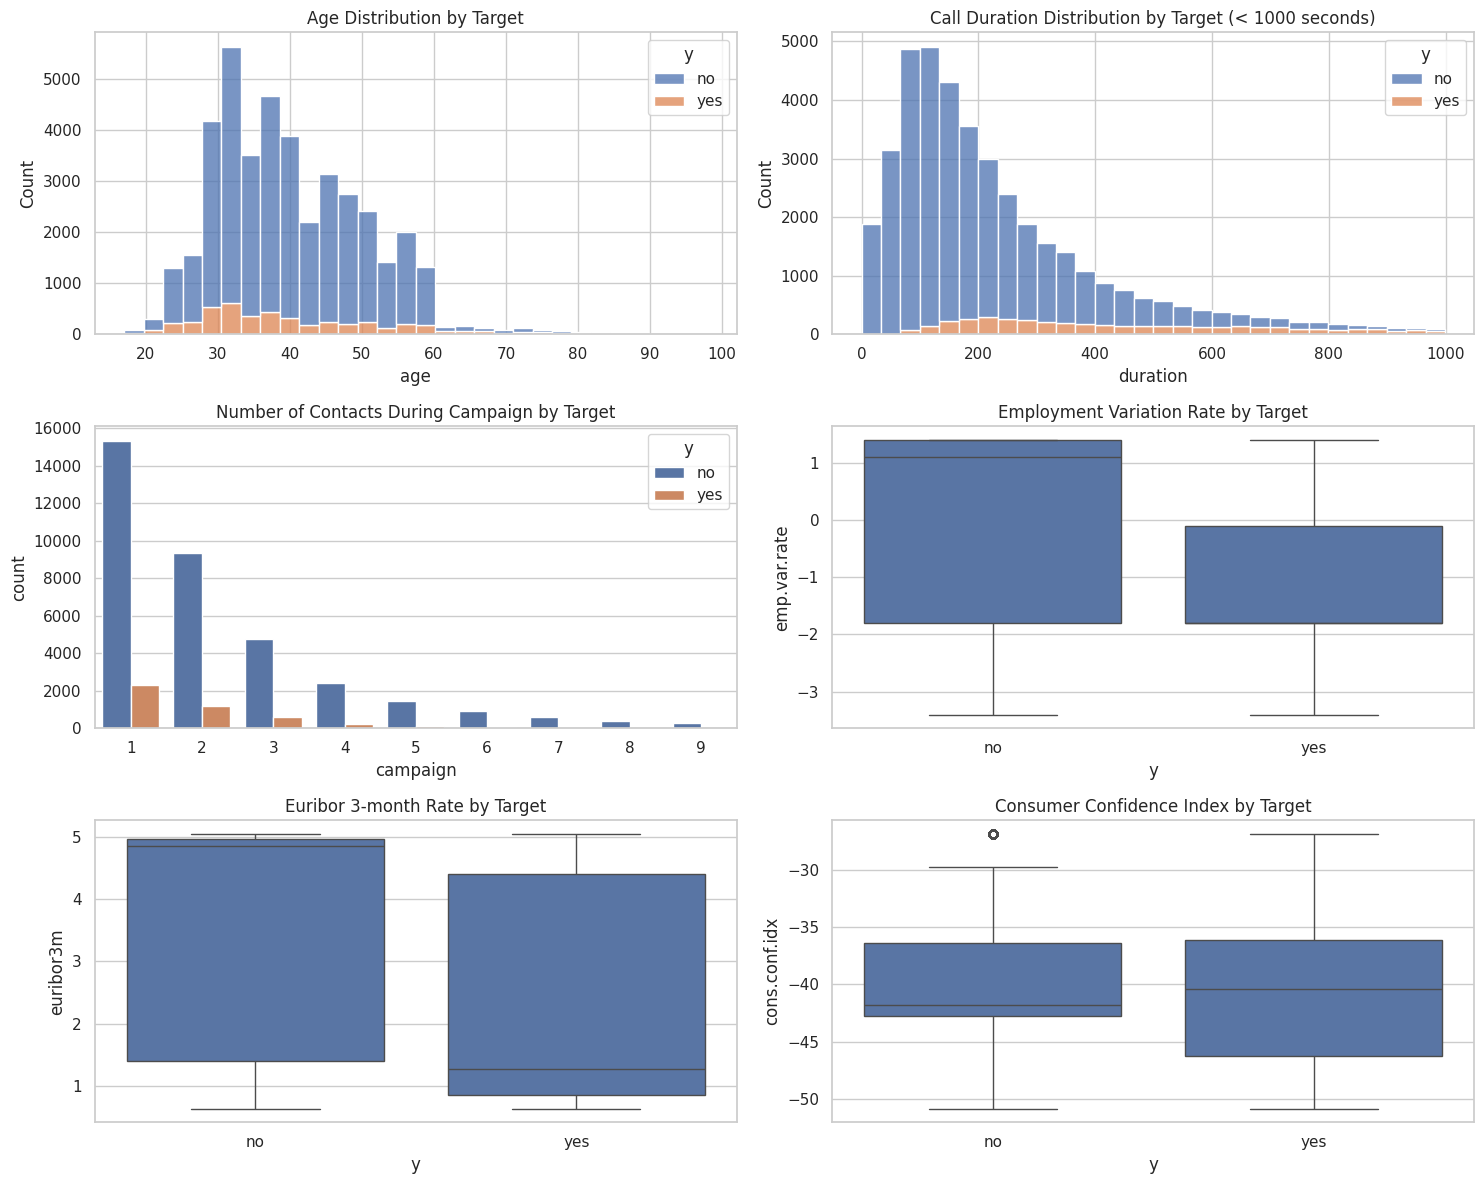

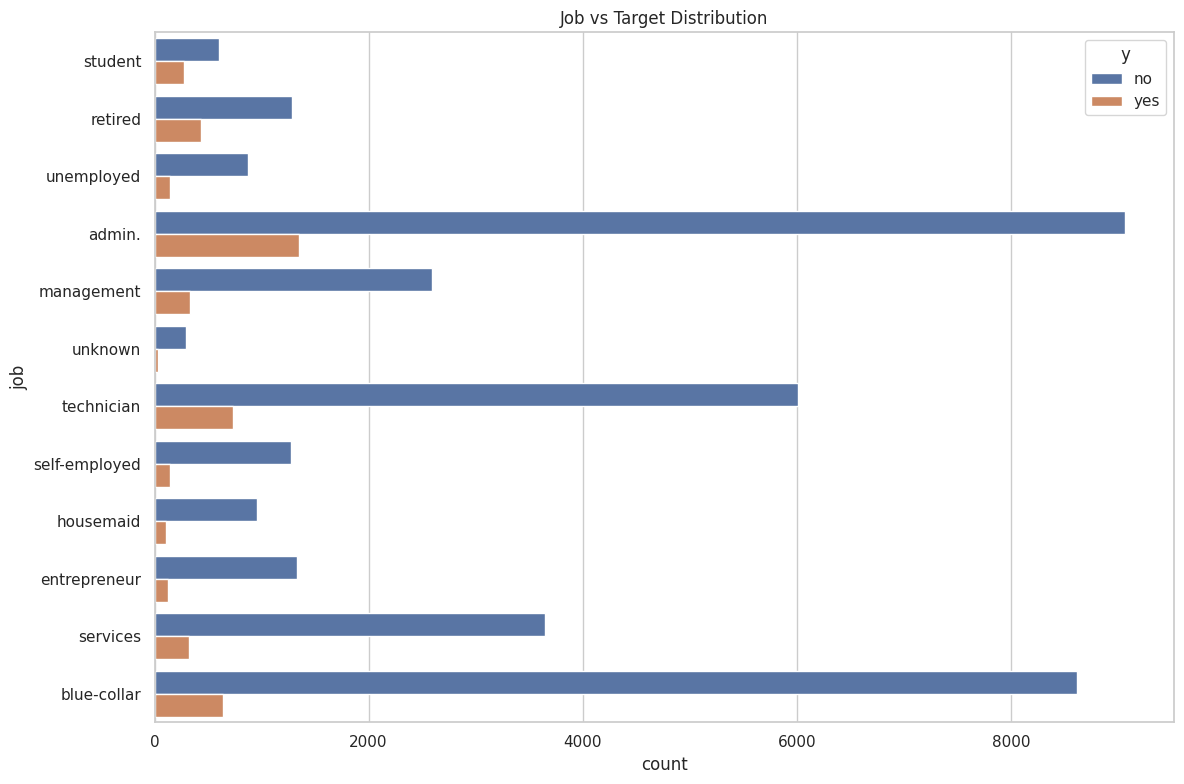

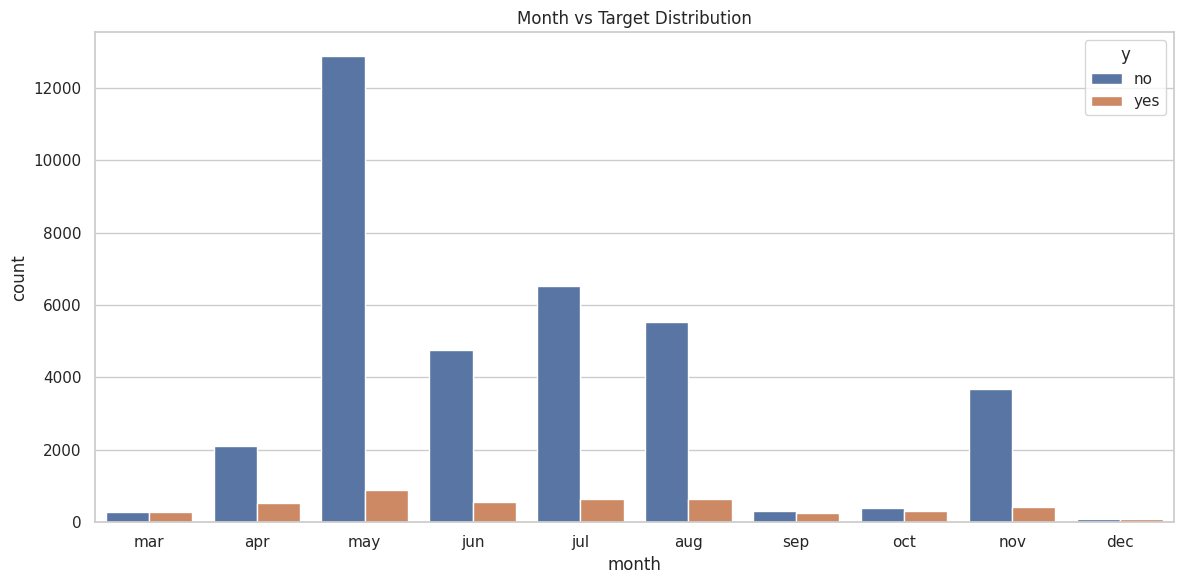

2025-04-10 03:40:50 - 
    Business Objective:
    To develop a predictive model that identifies clients likely to subscribe to a term deposit
    based on client information and campaign data. This will help the bank:

    1. Optimize marketing resource allocation by targeting clients with higher conversion probability
    2. Increase the conversion rate of marketing campaigns
    3. Reduce costs by minimizing contacts with low-probability clients
    4. Improve customer experience by reducing unwanted solicitations
    5. Maximize return on investment (ROI) for marketing campaigns

    The model's predictions will inform the prioritization of clients for contact in future
    marketing campaigns, leading to more efficient operations and higher subscription rates.
    
2025-04-10 03:40:50 - Prepared features (19 features) and target
2025-04-10 03:40:50 - Created feature preprocessor
2025-04-10 03:40:50 - Processed Features:
2025-04-10 03:40:50 - - Shape: (41188, 62)
2025-04-10 03:40:5

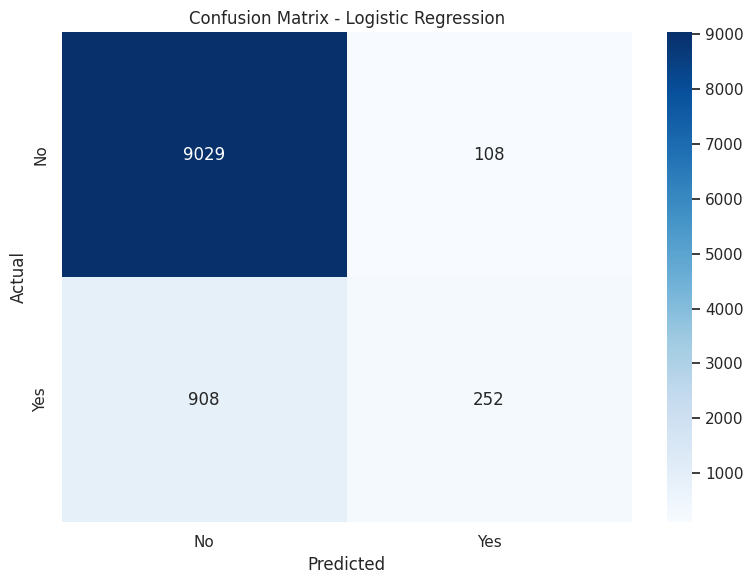

2025-04-10 03:40:50 - ============================================================

2025-04-10 03:40:50 - ============================================================
Training and Evaluating Logistic Regression:
2025-04-10 03:40:50 - 
+---------------+--------------+----------+
|    Metric     | Training Set | Test Set |
+---------------+--------------+----------+
| Training Time | 0.15 seconds |          |
|   Accuracy    |    0.8996    |  0.9013  |
|    ROC-AUC    |    0.7913    |  0.8052  |
|   F1 Score    |    0.3389    |  0.3316  |
+---------------+--------------+----------+
2025-04-10 03:40:50 - 
Classification Report:
2025-04-10 03:40:50 - 
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.909   | 0.988  |  0.947   | 9137.0  |
|      1       |    0.7    | 0.217  |  0.332   | 1160.0  |
|   accuracy   |   0.901   | 0.901  |  0.901   | 

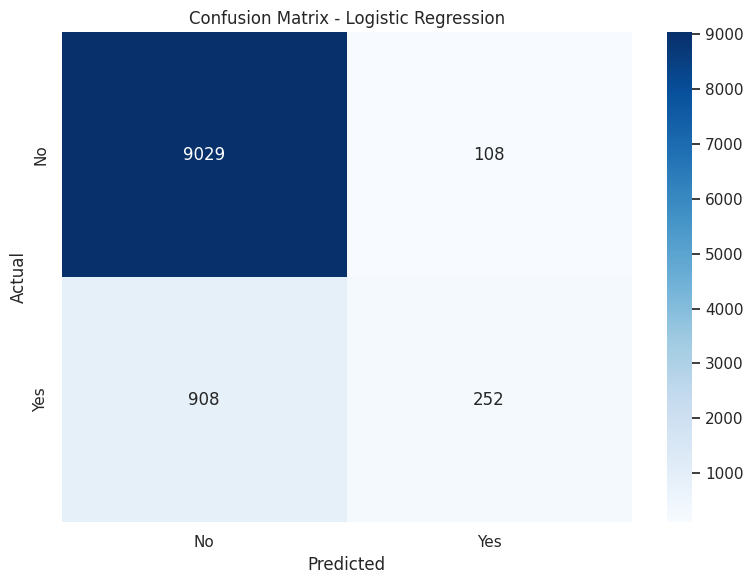

2025-04-10 03:40:51 - ============================================================

2025-04-10 03:40:51 - ============================================================
Training and Evaluating KNN:
2025-04-10 03:41:07 - 
+---------------+--------------+----------+
|    Metric     | Training Set | Test Set |
+---------------+--------------+----------+
| Training Time | 0.00 seconds |          |
|   Accuracy    |    0.9119    |  0.8977  |
|    ROC-AUC    |    0.9252    |  0.7452  |
|   F1 Score    |    0.4892    |  0.3986  |
+---------------+--------------+----------+
2025-04-10 03:41:07 - 
Classification Report:
2025-04-10 03:41:07 - 
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.916   | 0.974  |  0.944   | 9137.0  |
|      1       |   0.591   | 0.301  |  0.399   | 1160.0  |
|   accuracy   |   0.898   | 0.898  |  0.898   |  0.898  |
|  mac

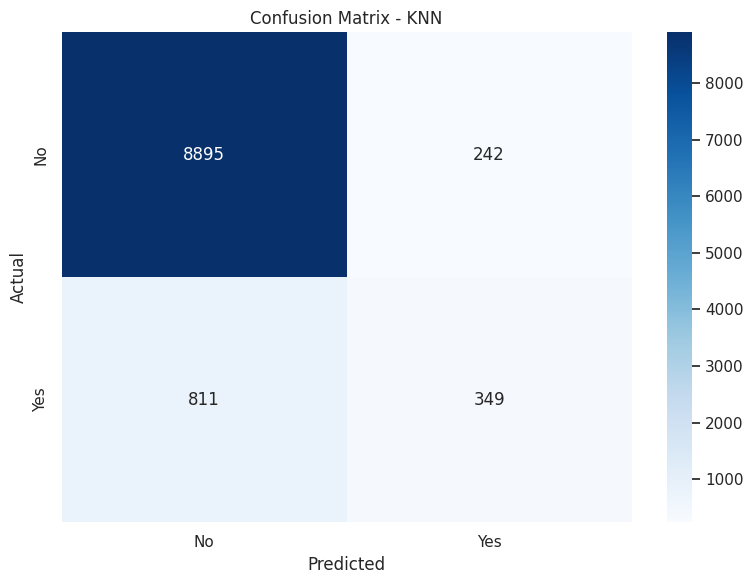

2025-04-10 03:41:07 - ============================================================

2025-04-10 03:41:07 - ============================================================
Training and Evaluating Decision Tree:
2025-04-10 03:41:08 - 
+---------------+--------------+----------+
|    Metric     | Training Set | Test Set |
+---------------+--------------+----------+
| Training Time | 0.24 seconds |          |
|   Accuracy    |    0.9959    |  0.8385  |
|    ROC-AUC    |    0.9999    |  0.6261  |
|   F1 Score    |    0.9813    |  0.3259  |
+---------------+--------------+----------+
2025-04-10 03:41:08 - 
Classification Report:
2025-04-10 03:41:08 - 
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.916   | 0.901  |  0.908   | 9137.0  |
|      1       |   0.308   | 0.347  |  0.326   | 1160.0  |
|   accuracy   |   0.838   | 0.838  |  0.838   |  0.838

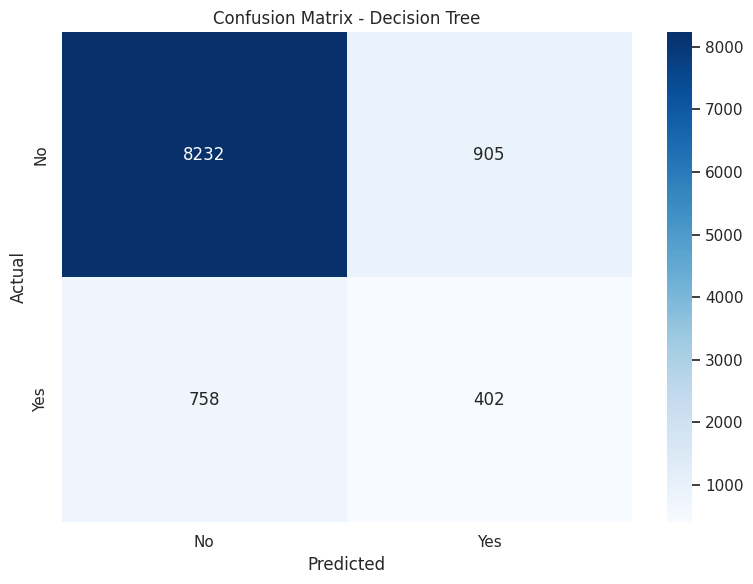

2025-04-10 03:41:08 - ============================================================

2025-04-10 03:41:08 - ============================================================
Training and Evaluating SVM:
2025-04-10 03:45:59 - 
+---------------+----------------+----------+
|    Metric     |  Training Set  | Test Set |
+---------------+----------------+----------+
| Training Time | 237.90 seconds |          |
|   Accuracy    |     0.9047     |  0.9035  |
|    ROC-AUC    |     0.8961     |  0.6974  |
|   F1 Score    |     0.3911     |  0.3701  |
+---------------+----------------+----------+
2025-04-10 03:45:59 - 
Classification Report:
2025-04-10 03:45:59 - 
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.912   | 0.986  |  0.948   | 9137.0  |
|      1       |   0.699   | 0.252  |   0.37   | 1160.0  |
|   accuracy   |   0.903   | 0.903  |  0.903   | 

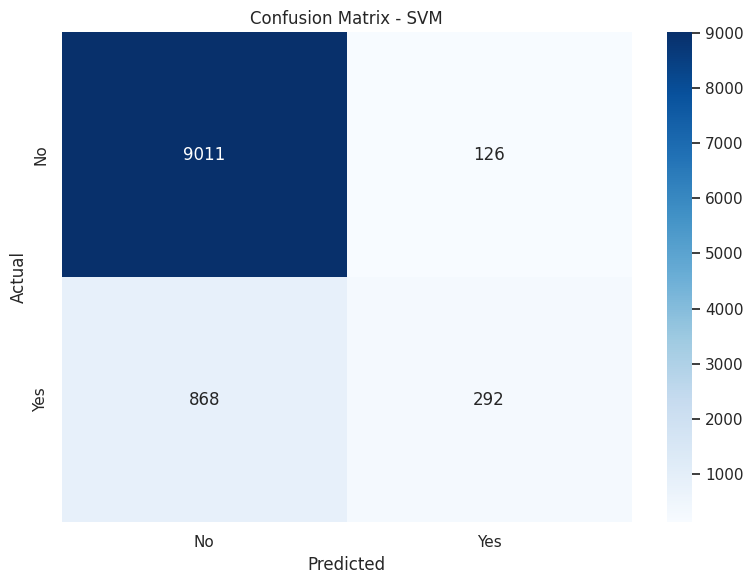

2025-04-10 03:45:59 - ============================================================

2025-04-10 03:45:59 - Model Comparison:
2025-04-10 03:45:59 -                      Train Time (s)  Train Accuracy  Test Accuracy  \
Model                                                                
Logistic Regression          0.1485          0.8996         0.9013   
KNN                          0.0046          0.9119         0.8977   
Decision Tree                0.2416          0.9959         0.8385   
SVM                        237.9049          0.9047         0.9035   

                     Train ROC-AUC  Test ROC-AUC  Train F1  Test F1  
Model                                                                
Logistic Regression         0.7913        0.8052    0.3389   0.3316  
KNN                         0.9252        0.7452    0.4892   0.3986  
Decision Tree               0.9999        0.6261    0.9813   0.3259  
SVM                         0.8961        0.6974    0.3911   0.3701  


<Figure size 1200x600 with 0 Axes>

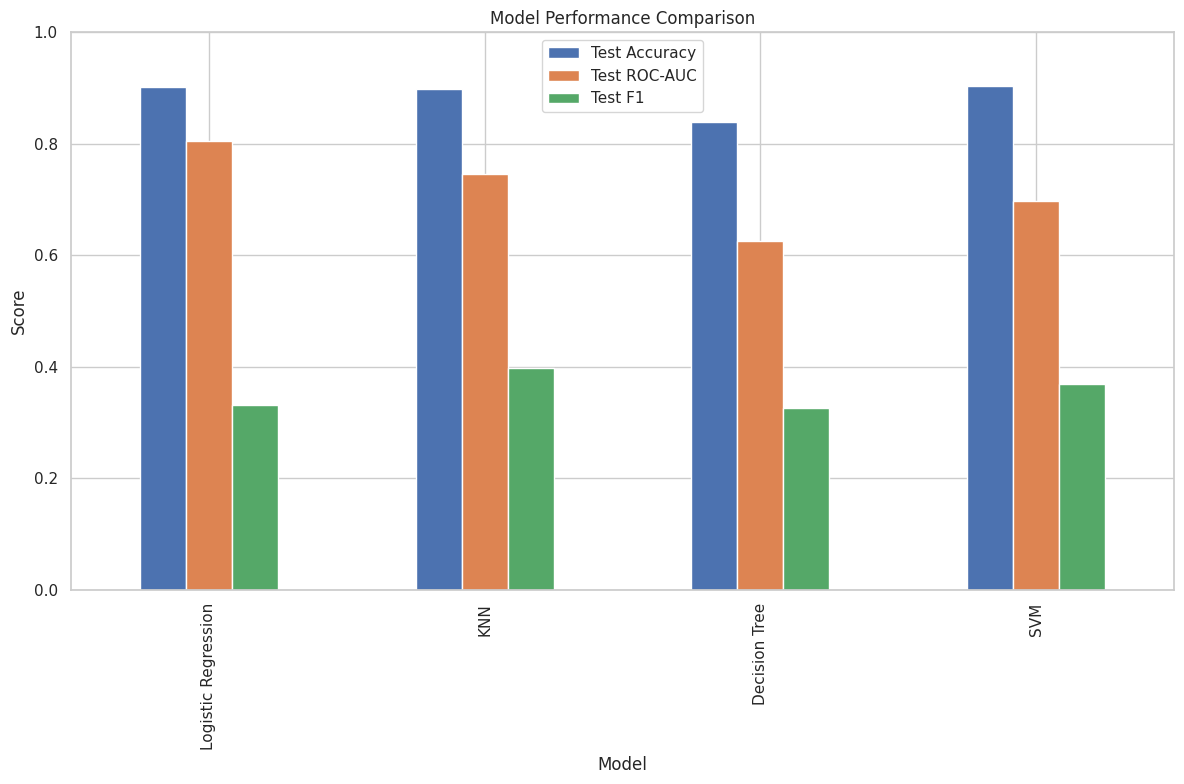

2025-04-10 03:45:59 - Completed model comparison
2025-04-10 03:45:59 - Tuning Logistic Regression Hyperparameters:


Optimizing Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-04-10 03:47:18 - Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
2025-04-10 03:47:18 - Best CV roc_auc score: 0.7882
2025-04-10 03:47:18 - ============================================================
Training and Evaluating Tuned Logistic Regression:
2025-04-10 03:47:20 - 
+---------------+--------------+----------+
|    Metric     | Training Set | Test Set |
+---------------+--------------+----------+
| Training Time | 1.55 seconds |          |
|   Accuracy    |    0.8288    |  0.8349  |
|    ROC-AUC    |    0.7932    |  0.8046  |
|   F1 Score    |    0.4499    |  0.4688  |
+---------------+--------------+----------+
2025-04-10 03:47:20 - 
Classification Report:
2025-04-10 03:47:20 - 
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.95    | 0.859  |  0.902   | 9137.0  |
|      1       |

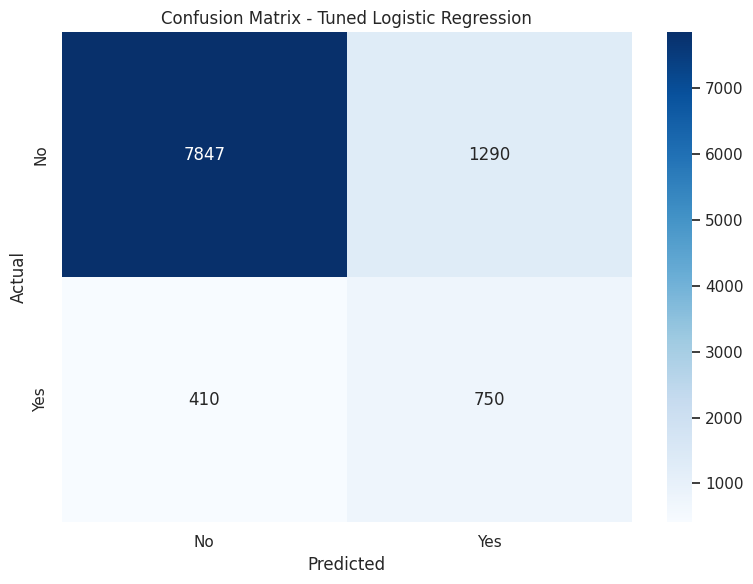

2025-04-10 03:47:20 - ============================================================

2025-04-10 03:47:20 - Completed hyperparameter tuning for Logistic Regression
2025-04-10 03:47:20 - Tuning KNN Hyperparameters:


Optimizing KNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-04-10 03:52:39 - Best parameters: {'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
2025-04-10 03:52:39 - Best CV roc_auc score: 0.7556
2025-04-10 03:52:39 - ============================================================
Training and Evaluating Tuned KNN:
2025-04-10 03:54:42 - 
+---------------+--------------+----------+
|    Metric     | Training Set | Test Set |
+---------------+--------------+----------+
| Training Time | 0.00 seconds |          |
|   Accuracy    |    0.9037    |  0.8993  |
|    ROC-AUC    |    0.8694    |  0.7769  |
|   F1 Score    |    0.4064    |  0.3595  |
+---------------+--------------+----------+
2025-04-10 03:54:42 - 
Classification Report:
2025-04-10 03:54:42 - 
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.912   | 0.982  |  0.945   | 9137.0  |
|      1       |   0.634   | 0.251  |  0.359   | 1160.0  |
| 

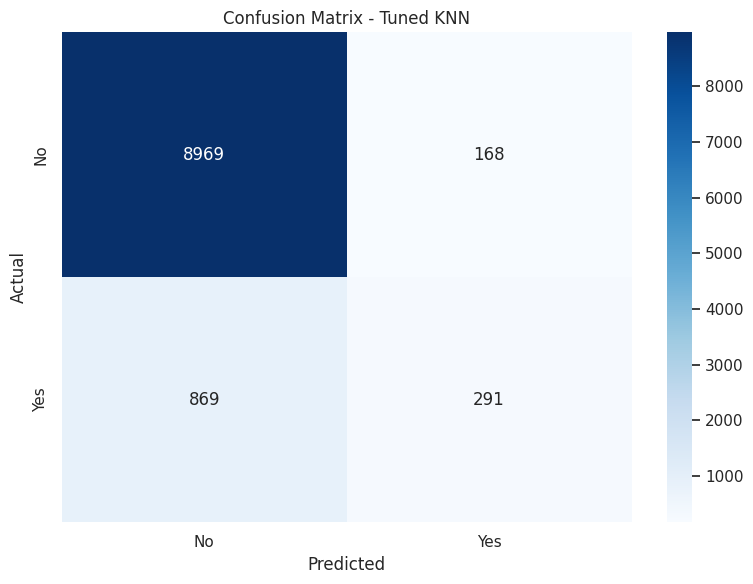

2025-04-10 03:54:43 - ============================================================

2025-04-10 03:54:43 - Completed hyperparameter tuning for KNN
2025-04-10 03:54:43 - Tuning Decision Tree Hyperparameters:


Optimizing Decision Tree...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


2025-04-10 03:55:19 - Best parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
2025-04-10 03:55:19 - Best CV roc_auc score: 0.7751
2025-04-10 03:55:19 - ============================================================
Training and Evaluating Tuned Decision Tree:
2025-04-10 03:55:19 - 
+---------------+--------------+----------+
|    Metric     | Training Set | Test Set |
+---------------+--------------+----------+
| Training Time | 0.09 seconds |          |
|   Accuracy    |    0.8452    |  0.8483  |
|    ROC-AUC    |    0.7835    |  0.7900  |
|   F1 Score    |    0.4695    |  0.4828  |
+---------------+--------------+----------+
2025-04-10 03:55:19 - 
Classification Report:
2025-04-10 03:55:19 - 
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.949   | 0.876  |  0.911   | 9137.0  |
|      1

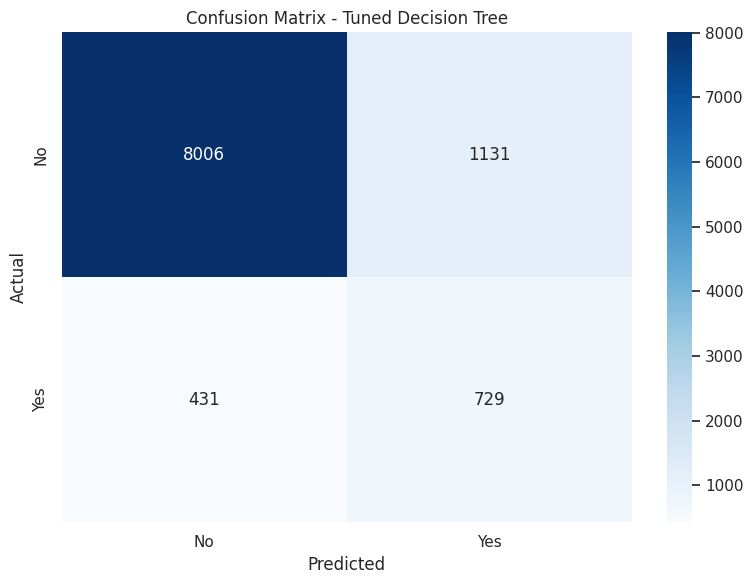

2025-04-10 03:55:19 - ============================================================

2025-04-10 03:55:19 - Completed hyperparameter tuning for Decision Tree
2025-04-10 03:55:19 - Tuning SVM Hyperparameters:
2025-04-10 03:55:19 - Using pre-configured RandomizedSearchCV for SVM


Optimizing SVM...


2025-04-10 04:00:29 - Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'C': 1}
2025-04-10 04:00:29 - Best CV roc_auc score: 0.6937
2025-04-10 04:00:29 - ============================================================
Training and Evaluating Tuned SVM:
2025-04-10 04:05:37 - 
+---------------+----------------+----------+
|    Metric     |  Training Set  | Test Set |
+---------------+----------------+----------+
| Training Time | 251.42 seconds |          |
|   Accuracy    |     0.9047     |  0.9035  |
|    ROC-AUC    |     0.8961     |  0.6974  |
|   F1 Score    |     0.3911     |  0.3701  |
+---------------+----------------+----------+
2025-04-10 04:05:37 - 
Classification Report:
2025-04-10 04:05:37 - 
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.912   | 0.986  |  0.948   | 9137.0  |
|      1       |   0.699   | 

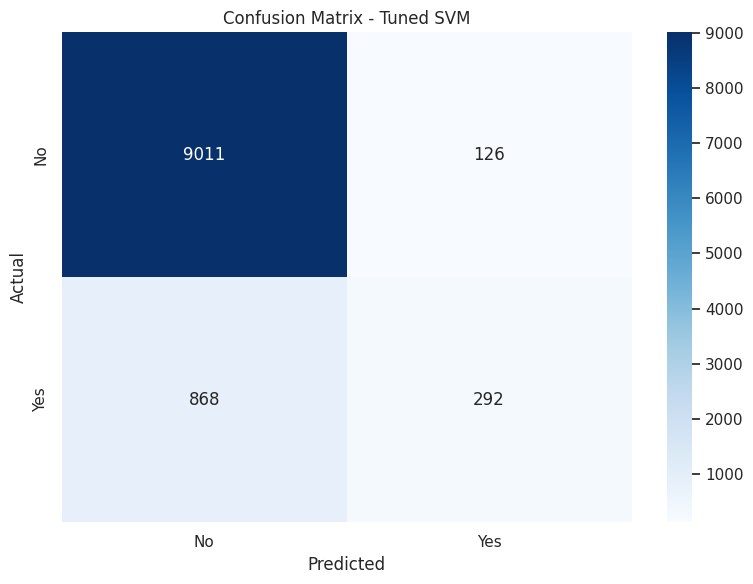

2025-04-10 04:05:37 - ============================================================

2025-04-10 04:05:37 - Completed hyperparameter tuning for SVM
2025-04-10 04:05:37 - Optimized Model Comparison:
2025-04-10 04:05:37 -                            Test Accuracy  Test ROC-AUC  Test F1
Model                                                          
Tuned Logistic Regression         0.8349        0.8046   0.4688
Tuned KNN                         0.8993        0.7769   0.3595
Tuned Decision Tree               0.8483        0.7900   0.4828
Tuned SVM                         0.9035        0.6974   0.3701


<Figure size 1200x600 with 0 Axes>

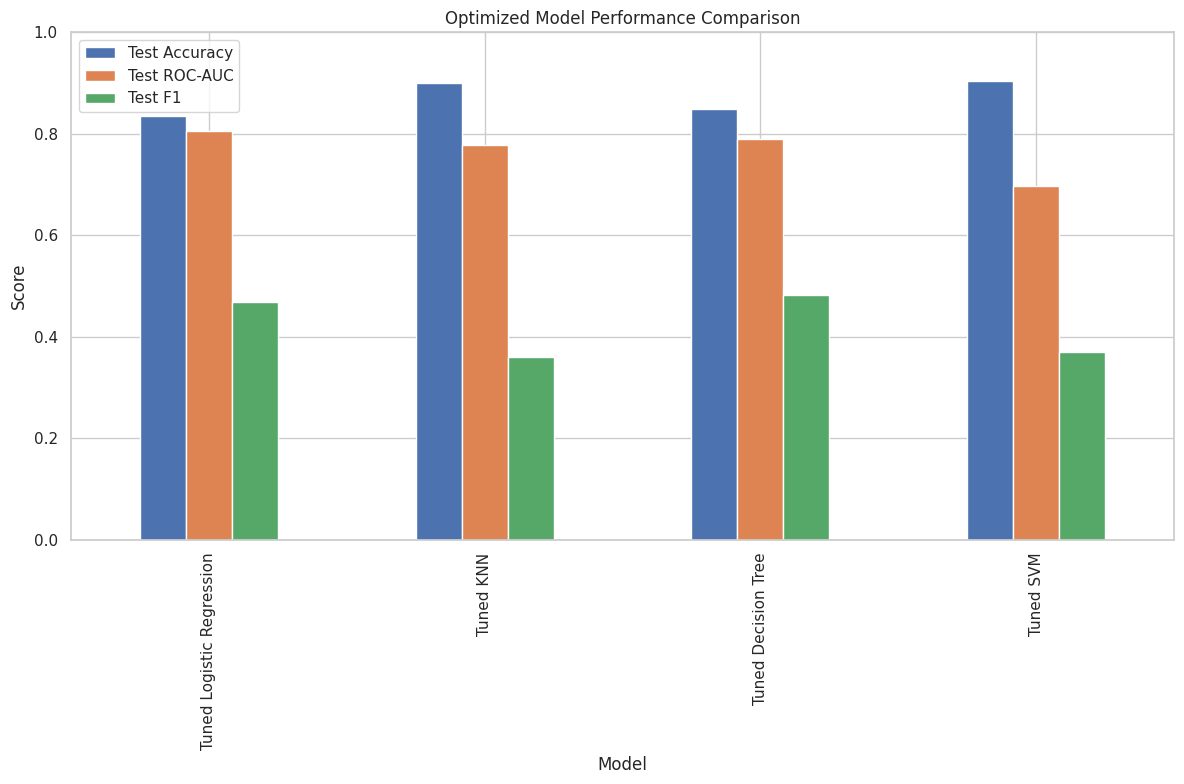

2025-04-10 04:05:37 - Best Model: Tuned Logistic Regression
2025-04-10 04:05:37 - Completed model optimization
2025-04-10 04:05:37 - Cross-validating the best model (Tuned Logistic Regression):
2025-04-10 04:05:37 - Cross-Validation Results (10-fold):
2025-04-10 04:06:00 - roc_auc: 0.3894 ± 0.2780
2025-04-10 04:06:19 - accuracy: 0.4136 ± 0.2880
2025-04-10 04:06:39 - f1: 0.1181 ± 0.0936
2025-04-10 04:06:39 - Completed cross-validation
2025-04-10 04:06:39 - Feature Importance Analysis for Tuned Logistic Regression:


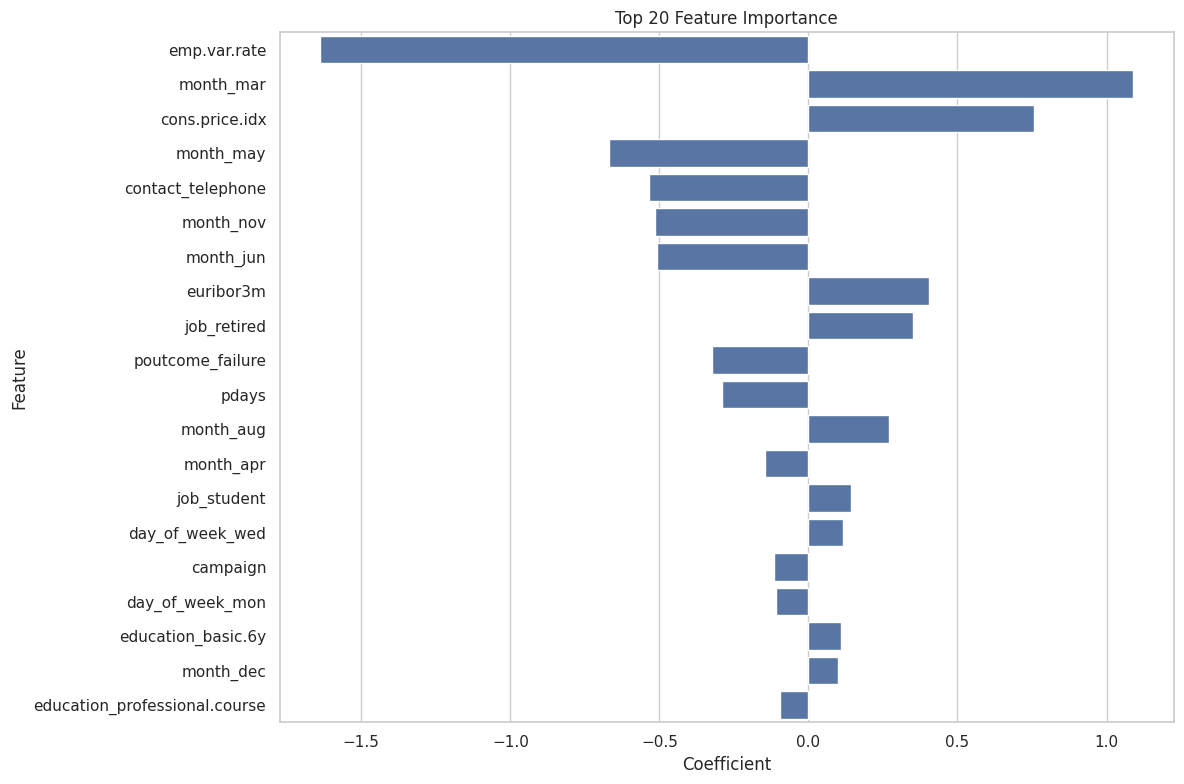

2025-04-10 04:06:39 - Completed feature importance analysis


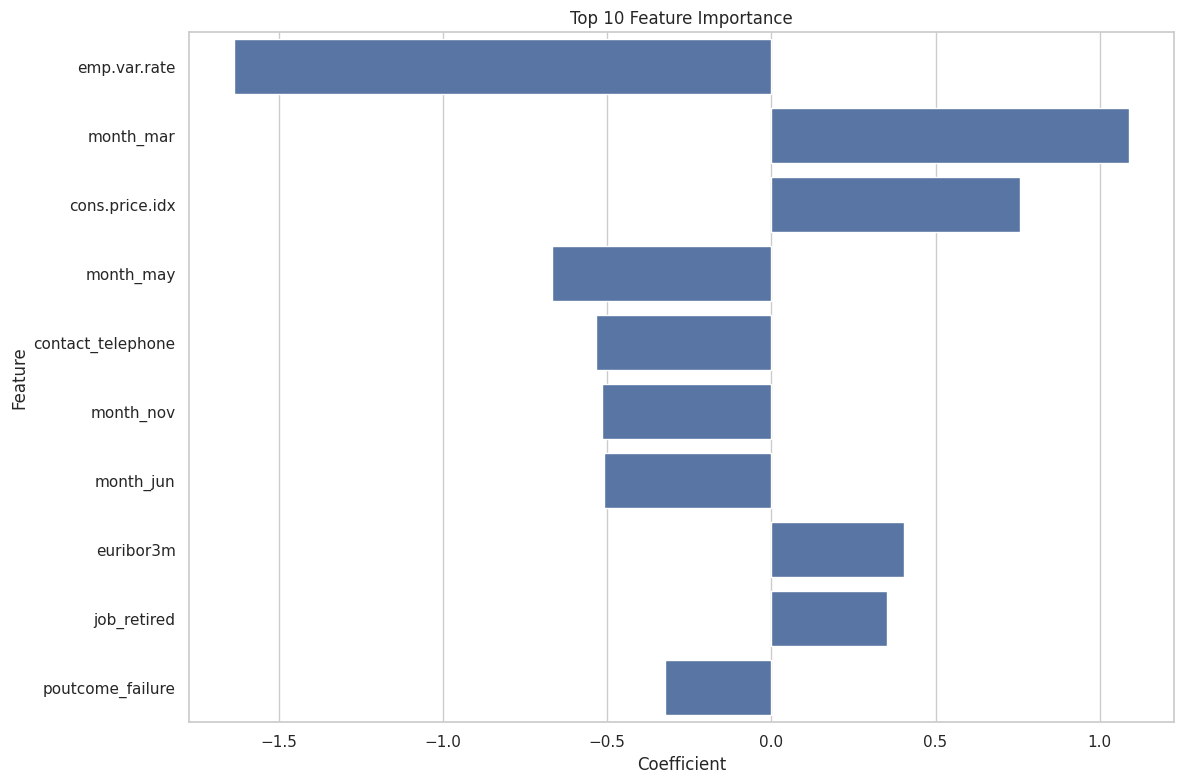

2025-04-10 04:06:39 - Completed feature importance analysis
2025-04-10 04:06:39 - Error generating business recommendations: 'generator' object is not subscriptable
2025-04-10 04:06:39 - 
2025-04-10 04:06:39 - ANALYSIS COMPLETED SUCCESSFULLY
2025-04-10 04:06:39 - ================================================================================


In [15]:
# Mount Google Drive first & create the directory if it doesn't exist
import os
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')
os.makedirs('/content/drive/MyDrive/BerkAIML/Module17/logs', exist_ok=True)

# Then create logs in your Drive
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_path = f'/content/drive/MyDrive/BerkAIML/Module17/logs/module17_{timestamp}.log'
logger = configureLogging(log_path)

# Load the dataset
df = load_data('/content/drive/MyDrive/BerkAIML/Module17/data/bank-additional-full.csv')

# Display the first few rows to understand the structure and display basic information
logger.info("Dataset Preview:")
# Temporarily change display settings
with pd.option_context('display.max_columns', None, 'display.expand_frame_repr', False, 'display.max_rows', 5, 'display.width', 1000):
    logger.info(f"{df.head()}")
    logger.info("Dataset Information:")
    logger.info(f"{df.info()}")

# Explore the dataset in detail
explore_data(df)

# Visualize key features: Age/Job/Month Distribution by Target, Call duration. Campaign Contacts, Economic Indicators (a few) etc.
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.figure(figsize=(15, 12))

# Age distribution
plt.subplot(3, 2, 1)
sns.histplot(data=df, x='age', hue='y', bins=30, multiple='stack')
plt.title('Age Distribution by Target')

# Call duration
plt.subplot(3, 2, 2)
sns.histplot(data=df[df['duration'] < 1000], x='duration', hue='y', bins=30, multiple='stack')
plt.title('Call Duration Distribution by Target (< 1000 seconds)')

# Campaign contacts
plt.subplot(3, 2, 3)
sns.countplot(data=df[df['campaign'] < 10], x='campaign', hue='y')
plt.title('Number of Contacts During Campaign by Target')

# Economic indicators
plt.subplot(3, 2, 4)
sns.boxplot(data=df, x='y', y='emp.var.rate')
plt.title('Employment Variation Rate by Target')

plt.subplot(3, 2, 5)
sns.boxplot(data=df, x='y', y='euribor3m')
plt.title('Euribor 3-month Rate by Target')

plt.subplot(3, 2, 6)
sns.boxplot(data=df, x='y', y='cons.conf.idx')
plt.title('Consumer Confidence Index by Target')

plt.tight_layout()
plt.show()

# Job distribution
plt.figure(figsize=(12, 8))
job_order = df.groupby('job')['y'].apply(lambda x: (x == 'yes').mean()).sort_values(ascending=False).index
sns.countplot(data=df, y='job', hue='y', order=job_order)
plt.title('Job vs Target Distribution')
plt.tight_layout()
plt.show()

# Month distribution
plt.figure(figsize=(12, 6))
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_order = [m for m in month_order if m in df['month'].unique()]
sns.countplot(data=df, x='month', hue='y', order=month_order)
plt.title('Month vs Target Distribution')
plt.tight_layout()
plt.show()

# ########### End Basic Analytics #############
# Define the business objective
business_objective = define_business_objective()
logger.info(business_objective)

# Prepare features and target variable
X, y = prepare_features_and_target(df, feature_set='all')

# Create and fit preprocessor
preprocessor = create_preprocessor(X)
X_processed = preprocessor.fit_transform(X)

# Get feature names after one-hot encoding
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
ohe = preprocessor.transformers_[1][1].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(numeric_cols) + list(cat_feature_names)

logger.info("Processed Features:")
logger.info(f"- Shape: {X_processed.shape}")
logger.info(f"- Number of features: {X_processed.shape[1]}")

# Split the data
X_train, X_test, y_train, y_test = train_test_data_split(X_processed, y)

logger.info("Data Split:")
logger.info(f"Training set: {X_train.shape}")
logger.info(f"Test set: {X_test.shape}")
logger.info(f"Training set target distribution: {np.bincount(y_train)}")
logger.info(f"Test set target distribution: {np.bincount(y_test)}")

# Calculate baseline performance
baseline_metrics = calculate_baseline(y_train, y_test)

# Train and evaluate a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_metrics, lr_model = train_and_evaluate_model(lr_model, X_train, y_train, X_test, y_test, "Logistic Regression")

# Compare all models
comparison_df, trained_models = compare_models(X_train, y_train, X_test, y_test)

# Optimize models (using smaller parameter grids for demonstration)
optimization_results = optimize_models(X_train, y_train, X_test, y_test)

# Cross-validate the best model
if optimization_results is not None:
    best_model = optimization_results['best_model']
    best_model_name = optimization_results['best_model_name']

    logger.info(f"Cross-validating the best model (Tuned {best_model_name}):")
    cv_results = cross_validate_model(best_model, X_processed, y)

    # Get feature importance
    logger.info(f"Feature Importance Analysis for Tuned {best_model_name}:")
    feature_importance = get_feature_importance(best_model, all_feature_names)

# Generate business insights and recommendations
if optimization_results is not None:
    best_model = optimization_results['best_model']
    best_model_name = optimization_results['best_model_name']

    # Get metrics for the best model
    best_metrics = {
        'test_accuracy': optimization_results['comparison_df'].loc[f'Tuned {best_model_name}', 'Test Accuracy'],
        'test_roc_auc': optimization_results['comparison_df'].loc[f'Tuned {best_model_name}', 'Test ROC-AUC'],
        'test_f1': optimization_results['comparison_df'].loc[f'Tuned {best_model_name}', 'Test F1']
    }

    # Generate recommendations
    generate_business_recommendations(best_model, all_feature_names, baseline_metrics, best_metrics)

logger.info("\n" + "="*80)
logger.info("ANALYSIS COMPLETED SUCCESSFULLY")
logger.info("="*80)